In [1]:
%load_ext autoreload
%autoreload 2

## AGN Variablity Metric \#1
This metric examines the number of visit at each location in the WFD area to ensure reliable fitting of CARMA models to AGN light curves generated. The minimum requirement is **60** epochs over the course of 10 years, and **100** epochs would be better. 

This notebook demonstrate how to run such a metric on opsims using the MAF for u band and g band observations. Redder filters are less concerned since they have much more observations than the u and g. The summary statistics I used to compare opsims are `FracAbove_60` and `FracAbove_100`, which stand for the fraction of the WFD survey area that can be visited more 60 times and 100 times respectively. 

### 0. Software Setup

In [1]:
your_username = 'ywx649999311'

In [2]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

In [37]:
import matplotlib as mpl
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.2,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
#     "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 20,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 20,
    "legend.fontsize": 20,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 20,              # Font size of numbers 
    "ytick.labelsize": 20,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
#     "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
#     "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
#         r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
#         ]
    }

mpl.rcParams.update(pgf_with_latex)

Import the sims_maf modules needed.

In [3]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [4]:
# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

In [5]:
# import convenience functions
from opsimUtils import *

### 1. Define `MagErr` Stacker

In [8]:
# gamma = {'u': 0.038, 'g':0.039, 'r':0.039, 'i':0.039, 'z':0.039, 'y':0.039}
# sigmaSys = {'u':0.0075, 'g':0.005, 'r':0.005, 'i':0.005, 'z':0.0075, 'y':0.0075}

# def varRand(mag, m5, gamma):
#     m5 = np.array(m5)
#     diffM = mag - m5
#     return (0.04-gamma)*np.power(10, 0.4*diffM) + gamma*np.power(10, 0.8*diffM)

# varRand(23, np.array([23.1, 22.9]), 0.039)

In [9]:
class MagErrStacker(stackers.BaseStacker):
    """
    Calculate the Photometric error given the brightness of an object in magnitude. 
    
    
    The photometric error is obtained using eqn #4 and #5 from the overview paper with 
    the gamma values provided by table #2 in the same paper.
    """
    colsAdded = []
    gamma = {'u': 0.038, 'g':0.039, 'r':0.039, 'i':0.039, 'z':0.039, 'y':0.039}
    sigmaSys = {'u':0.0075, 'g':0.005, 'r':0.005, 'i':0.005, 'z':0.0075, 'y':0.0075}
    
    def __init__(self, magnitude, m5Col = 'fiveSigmaDepth', filterCol='filter'):
        self.units = ['mag']
        self.colsReq = [m5Col, filterCol]
        self.filterCol = filterCol
        self.m5Col = m5Col
        
        # if magnitude single value, make it an array
        if not hasattr(magnitude, '__iter__'):
            magnitude = [magnitude]
        self.mag = magnitude
        
        # given the list of magnitudes, add cols to create
        magErr_temp = 'magErr_{}'
        for mag in self.mag:
            self.colsAdded.append(magErr_temp.format(mag))


    def varRand(self, mag, m5, gamma):
        """Compute random noise using eqn #5
        """
        
        m5 = np.array(m5) # convert to array for broadcasting
        diffM = mag - m5
        return (0.04-gamma)*np.power(10, 0.4*diffM) + gamma*np.power(10, 0.8*diffM)
    
    
    def _run(self, simData, cols_present=False):
        if cols_present:
            # Column already present in data; assume it needs updating and recalculate.
            return simData
        filts = np.unique(simData[self.filterCol])
        for filtername in filts:
            infilt = np.where(simData[self.filterCol] == filtername)
            
            for mag in self.mag:
                simData['magErr_{}'.format(mag)][infilt] = np.sqrt(self.varRand(mag,
                                                                   simData[infilt][self.m5Col],
                                                                   self.gamma[filtername]) + 
                                                          sigmaSys[filtername]**2)

            
        return simData


In [10]:
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.5/'
outDir = '../tmp/PhotoMetric/ResultDBs/'
metricDataPath = '../tmp/PhotoMetric/MetricData/'

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

In [11]:
# two dictionary are returned by the following function, 
# One (opSimDbs) is a dictionary storing all database objects
# Another (resultDbs) is a dictionary consist of the objects directing MAF where to save metric metadata
# Both dictionaries are indexed by OpSim run names
opSimDbs, resultDbs = connect_dbs(dbDir, outDir)

In [12]:
dbRuns = show_opsims(dbDir)
dbRuns[0:5] # only show first 5 opsims

['dcr_nham1_ugri_v1.5_10yrs',
 'rolling_mod6_sdf_0.20_v1.5_10yrs',
 'wfd_depth_scale0.95_noddf_v1.5_10yrs',
 'u60_v1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs']

### 2. Test the Stacker \& Explore Metric

In [13]:
ddfInfo(opSimDbs[dbRuns[1]], 'COSMOS')

{'proposalId': 3, 'Coord': (150.11, 2.14)}

In [14]:
passmetric = metrics.PassMetric(cols=['fiveSigmaDepth'])
slicer = slicers.UserPointsSlicer(ra=[150.11], dec=[2.14])
constraint = 'filter = "g"'

testBundle = metricBundles.MetricBundle(passmetric, slicer, constraint, \
                                        stackerList=[MagErrStacker([20, 21, 22, 23])])

In [15]:
testBDict = {'passMagErr': testBundle}
mg = metricBundles.MetricBundleGroup(testBDict, opSimDbs[dbRuns[1]], \
                                     outDir=outDir, resultsDb=resultDbs[dbRuns[1]])
mg.runAll()

Querying database SummaryAllProps with constraint filter = "g" for columns ['fiveSigmaDepth', 'fieldRA', 'filter', 'fieldDec']
Found 228130 visits
Running:  ['passMagErr']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [16]:
data = testBundle.metricValues.data[0]
testBundle.metricValues.data[0][:10]

array([(24.25252438, 150.15263246, 'g', 0.4370119 , 0.0077692 , 0.01313436, 0.02767383, 0.06498   ),
       (24.33777643, 150.40169539, 'g', 0.59686845, 0.00752404, 0.01243239, 0.02582524, 0.06028613),
       (24.05705755, 150.51971538, 'g', 0.68317611, 0.00842527, 0.0149879 , 0.03251575, 0.07724719),
       (24.74727782, 150.62744482, 'g', 0.63788375, 0.00662065, 0.00979276, 0.01876013, 0.04225459),
       (24.13825749, 150.28162477, 'g', 0.74779949, 0.00813574, 0.0141741 , 0.03039603, 0.07188091),
       (24.68316813, 150.07053475, 'g', 0.52650418, 0.00673642, 0.01013606, 0.0196923 , 0.04464545),
       (24.726519  , 150.07053475, 'g', 0.52650418, 0.00665724, 0.00990142, 0.0190557 , 0.04301321),
       (24.91077656, 151.4701026 , 'g', 2.05408273, 0.00636028, 0.00901517, 0.01662819, 0.03676541),
       (24.64898008, 151.46689206, 'g', 1.86644194, 0.00680162, 0.01032873, 0.02021336, 0.04597988),
       (24.37624315, 151.4021213 , 'g', 1.04066534, 0.00742072, 0.01213485, 0.0250386 , 0.0

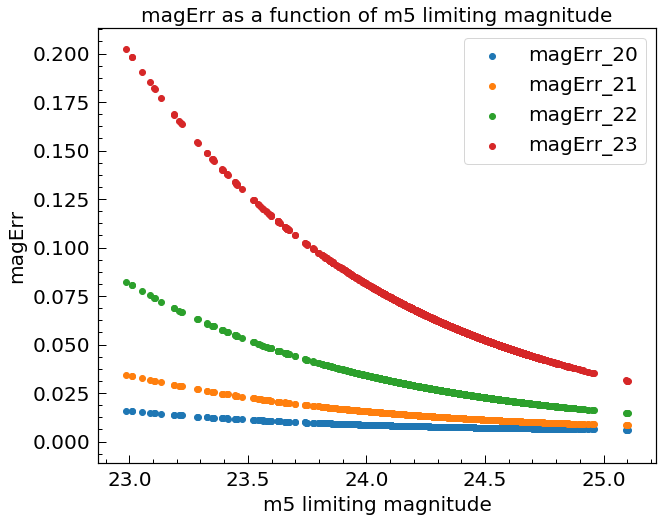

In [46]:
fig = plt.figure(figsize=(10,8))
g_data = data[data['filter'] == 'g']
plt.scatter(g_data['fiveSigmaDepth'], g_data['magErr_20'], label='magErr_20')
plt.scatter(g_data['fiveSigmaDepth'], g_data['magErr_21'], label='magErr_21')
plt.scatter(g_data['fiveSigmaDepth'], g_data['magErr_22'], label='magErr_22')
plt.scatter(g_data['fiveSigmaDepth'], g_data['magErr_23'], label='magErr_23')
plt.title('magErr as a function of m5 limiting magnitude', fontsize=20)
plt.xlabel('m5 limiting magnitude', fontsize=20)
plt.ylabel('magErr', fontsize=20)
plt.legend(fontsize=20)

Text(0, 0.5, 'Counts')

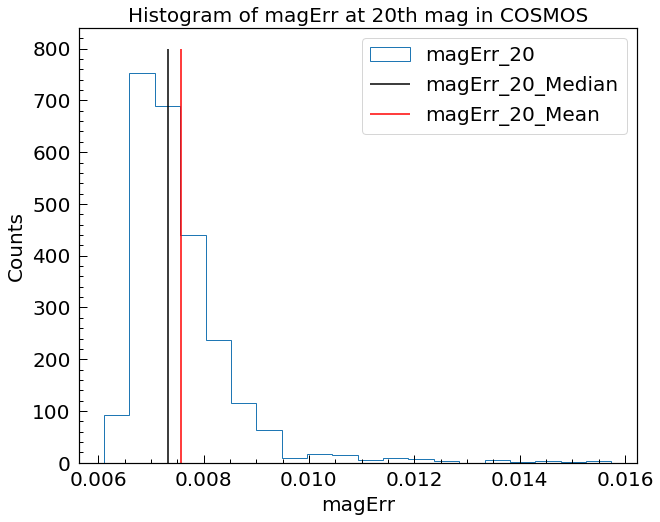

In [45]:
fig = plt.figure(figsize=(10,8))
_ = plt.hist(g_data['magErr_20'],bins=20, histtype='step', label='magErr_20')
_ = plt.vlines(x=np.median(g_data['magErr_20']), ymin=0, ymax=800, label='magErr_20_Median')
_ = plt.vlines(x=np.mean(g_data['magErr_20']), ymin=0, ymax=800, colors='r', label='magErr_20_Mean')
plt.legend(fontsize=20)
plt.title('Histogram of magErr at 20th mag in COSMOS', fontsize=20)
plt.xlabel('magErr', fontsize=20)
plt.ylabel('Counts', fontsize=20)

We can see the mean is larger than the median. Since the power of a white noise process is just the variance of the noise, thus it doesn't hurt to assume a higher level of noise power, thus we will use the mean statistic to summarize the photometric error for all visits at a particular point on the sky. 

### 3. Declare some metrics to run on above OpSims

In [16]:
# nVisit Metric in U band
uMagErrMetric = metrics.MeanMetric(col='magErr_23', metricName='uMagErr_23_mean')
magErrSlicer = slicers.HealpixSlicer(nside=64)
uMagErrConstraint = 'filter = "u"'
uMagErrConstraint += ' and note not like "DD%"'
uMagErrConstraint += ' and proposalId = 1'

uMagErr = metricBundles.MetricBundle(uMagErrMetric, magErrSlicer, \
                uMagErrConstraint, stackerList=[MagErrStacker([23])])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [16]:
# nVisit Metric in U band
gMagErrMetric = metrics.MeanMetric(col='magErr_23', metricName='gMagErr_23_mean')
magErrSlicer = slicers.HealpixSlicer(nside=64)
gMagErrConstraint = 'filter = "g"'
gMagErrConstraint += ' and note not like "DD%"'
gMagErrConstraint += ' and proposalId = 1'

gMagErr = metricBundles.MetricBundle(gMagErrMetric, magErrSlicer, \
                gMagErrConstraint, stackerList=[MagErrStacker([23])])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [18]:
# # set summary statistics
# summaryMetrics = [metrics.FracAboveMetric(cutoff=60, metricName='FracAbove_60'),
#                   metrics.FracAboveMetric(cutoff=100, metricName='FracAbove_100')]
# nVisitU.setSummaryMetrics(summaryMetrics)
# nVisitG.setSummaryMetrics(summaryMetrics)

In [19]:
# create a bundleDict for all metrics to run on each opSim
bundleDict = {'uMagErrMetric': uMagErrMetric, 'gMagErrMetric': gMagErrMetric}

### 2. Loop over all OpSims in dbDir and run MAF
While constructing a metricBundleGroup from a dictionary (the cell below), you will need to provide the path to a directory (`metricDataPath` in the cell below) where you would like to store the metric data (this is **DIFFERENT** than path to the metric data, `outDir`). To construct metricbundles for plotting and further analysis, this path will be needed.

In [20]:
# below I am only going to run metrics on the first five opsims
for run in dbRuns[0:5]:
    # must set run name for each opSim to store metric data into
    # separate files
    print(f'Running metrics on: {run}')
    print('*************************************')
    nVisitU.setRunName(run)
    nVisitG.setRunName(run)
    metricGroup = metricBundles.MetricBundleGroup(bundleDict,\
                    opSimDbs[run], metricDataPath, resultDbs[run], verbose=False)
    metricGroup.runAll()

Running metrics on: dcr_nham1_ugri_v1.5_10yrs 

*************************************
Running metrics on: rolling_mod6_sdf_0.20_v1.5_10yrs 

*************************************
Running metrics on: wfd_depth_scale0.95_noddf_v1.5_10yrs 

*************************************
Running metrics on: u60_v1.5_10yrs 

*************************************
Running metrics on: footprint_stuck_rollingv1.5_10yrs 

*************************************


### 3. Now Visualize Summary Stat

In [23]:
# show avaiable summary
getSummaryStatNames(resultDbs[dbRuns[0]], 'nVisitG')

[{'metricId': 1, 'StatNames': ['FracAbove_100', 'FracAbove_60']}]

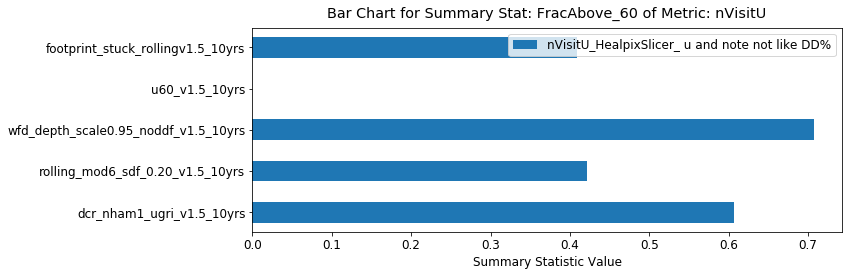

In [52]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitU', 'FracAbove_60', runNames=dbRuns[0:5])

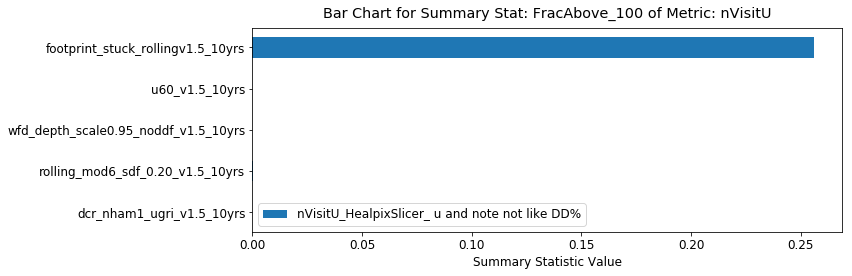

In [53]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitU', 'FracAbove_100', runNames=dbRuns[0:5])

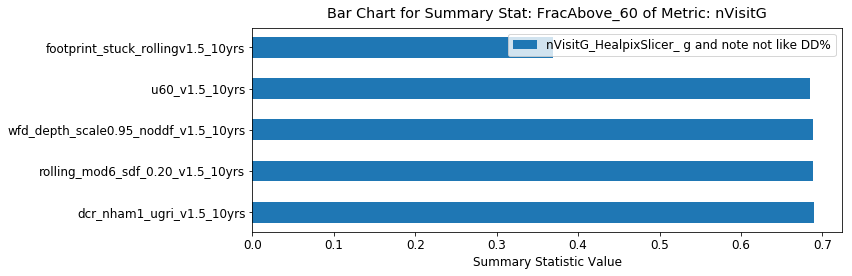

In [51]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitG', 'FracAbove_60', runNames=dbRuns[0:5])

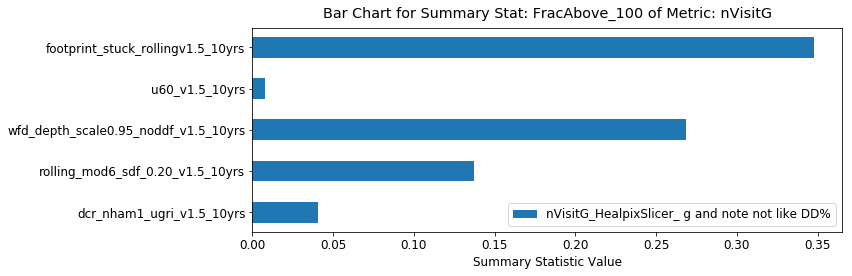

In [54]:
# compare using plotSummaryBar
plotSummaryBarh(resultDbs, 'nVisitG', 'FracAbove_100', runNames=dbRuns[0:5])